In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error,mean_absolute_error
from rdkit.Chem import AllChem, Descriptors, MolFromSmiles
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedShuffleSplit, RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [11]:
#counting for null values
photoswitches = pd.read_csv('./photoswitches.csv')
null_columns = photoswitches.columns[photoswitches.isnull().any()]
photoswitches[null_columns].isnull().sum()

rate of thermal isomerisation from Z-E in s-1             330
Solvent used for thermal isomerisation rates              353
Z PhotoStationaryState                                    329
E PhotoStationaryState                                    331
E isomer pi-pi* wavelength in nm                           13
Extinction                                                372
E isomer n-pi* wavelength in nm                           264
Extinction coefficient in M-1 cm-1                        379
Z isomer pi-pi* wavelength in nm                          312
Extinction.1                                              393
Z isomer n-pi* wavelength in nm                           282
Extinction coefficient in M-1 cm-1.1                      382
Wiberg index                                              390
E-Z irradiation wavelength in nm                          341
Z-E irradiation wavelength                                341
Irradiation solvent                                       184
PBE0 DFT

In [12]:
#data cleaning on photoswitch datasets
photoswitches.rename({"Unnamed: 0":"a"}, axis="columns", inplace=True)
dropped_data = photoswitches.drop(columns = ['a','BHLYP/6-31G* DFT E isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT E isomer n-pi* wavelength in nm','BHLYP/6-31G* Z isomer pi-pi* wavelength in nm','BHLYP/6-31G* DFT Z isomer n-pi* wavelength in nm'])
dropped_data.to_csv ('rawdata_new.csv', index = False)

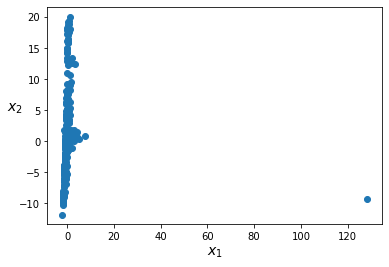

In [3]:
#PCA for morgan fingerprints
morganfingerprints = pd.read_csv('./morgan_fingerprints.csv')
morganfingerprints_num = morganfingerprints.drop(morganfingerprints.columns[[0, 1]], axis = 1)
X = morganfingerprints_num
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
reduced_morgfingerprint = pca.fit_transform(X_scaled)
plt.scatter(reduced_morgfingerprint[:, 0], reduced_morgfingerprint[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

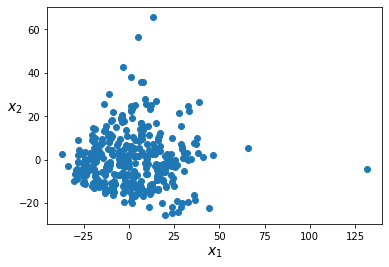

In [4]:
#PCA for mordred
mordred = pd.read_csv('./mordred_descriptors.csv')
mordred_num = mordred.drop(mordred.columns[[0, 1]], axis = 1)
X_1 = mordred_num
scaler = StandardScaler()
X1_scaled = scaler.fit_transform(X_1)
pca = PCA(n_components=2)
reduced_mordred = pca.fit_transform(X1_scaled)
plt.scatter(reduced_mordred[:, 0], reduced_mordred[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

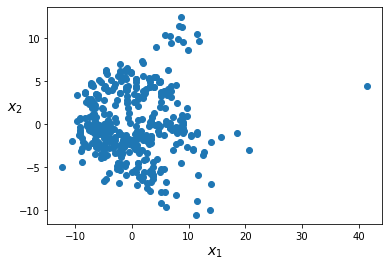

In [5]:
#PCA for rdkit descriptors
rd_descriptor = pd.read_csv('./rdkit_descriptors.csv')
rd_descriptor_clean = rd_descriptor.drop(rd_descriptor.columns[[0, 1]], axis = 1)
X = rd_descriptor_clean
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
reduced_descriptor = pca.fit_transform(X_scaled)
plt.scatter(reduced_descriptor[:, 0], reduced_descriptor[:, 1])
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.show()

In [17]:
#RF-reduced morganf prediction
df_new = pd.read_csv('rawdata_new.csv')
df_reduced = pd.DataFrame(reduced_morgfingerprint)
df_joined_mgf = pd.merge(df_new, df_reduced, left_index=True, right_index=True)
df_test = df_joined_mgf[df_joined_mgf['E isomer pi-pi* wavelength in nm'].isnull()]
df_train = df_joined_mgf[df_joined_mgf['E isomer pi-pi* wavelength in nm'].notnull()]
X_hasvalue = df_train[[0, 1]]
y_hasvalue = df_train['E isomer pi-pi* wavelength in nm']
X_test = df_test[[0, 1]]
y_test= df_test['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
random_forest = RandomForestRegressor(n_estimators=1000,oob_score = True, max_features = "auto")
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

29.09057990767736
[348.469  333.98   348.7075 339.464  334.037  334.28   333.458  340.471
 338.074  364.1485 359.464  347.047  328.176 ]


In [26]:
#make the standard code into a function for prediction models
def prediction_model(reduced_something, wavelength):    
    df_reduced = pd.DataFrame(reduced_something)
    df_joined = pd.merge(df_new, df_reduced, left_index=True, right_index=True)
    df_test = df_joined[df_joined[wavelength].isnull()]
    df_train = df_joined[df_joined[wavelength].notnull()]
    X_hasvalue = df_train[[0, 1]]
    y_hasvalue = df_train[wavelength]
    X_test = df_test[[0, 1]]
    y_test= df_test[wavelength]
    X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
    random_forest = RandomForestRegressor(n_estimators=1000)
    random_forest.fit(X_train, y_train) 
    y_pred = random_forest.predict(X_validation)
    mae = mean_absolute_error(y_validation, y_pred)
    mse = mean_squared_error(y_validation, y_pred)
    rmse = np.sqrt(mse)
    r_two = r2_score(y_validation, y_pred)
    return {'mae': mae, 'rmse': rmse,'r2': r_two}

rdkit_scores = prediction_model(reduced_descriptor, 'E isomer pi-pi* wavelength in nm')
mordred_scores = prediction_model(reduced_mordred, 'E isomer pi-pi* wavelength in nm')
print(rdkit_scores,mordred_scores)

{'mae': 30.67599122934888, 'rmse': 42.87985055338213, 'r2': 0.5625423325321366} {'mae': 27.3290229834791, 'rmse': 39.01197768547511, 'r2': 0.6379025710990738}


In [15]:
#k-fold cross validation for evaluating the performance of the training model
kf = KFold(n_splits=10, shuffle=True, random_state=10)
kf.get_n_splits(X_hasvalue)
for train_index, test_index in kf.split(X_hasvalue):
    X_train, X_test = X_hasvalue.iloc[train_index], X_hasvalue.iloc[test_index]
    y_train, y_test = y_hasvalue.iloc[train_index], y_hasvalue.iloc[test_index]
    random_forest.fit(X_train, y_train) 
score = cross_val_score(random_forest, X_hasvalue, y_hasvalue, cv = kf)
print(score)
print(score.mean())

[0.56063104 0.66716914 0.60811089 0.53207415 0.47408708 0.4426716
 0.59448665 0.73780684 0.37331792 0.5976378 ]
0.5587993101226152


In [16]:
#read the clustering csv file
df_kmeans = pd.read_csv('kmeans.csv')
df_kmeans

,Unnamed: 0,SMILES,PC1,PC2,PC3,PC4,PC5,PC6,PC1_normalized,PC2_normalized,Cluster_PC1_PC2,cluster
0,0,C[N]1N=NC(=N1)N=NC2=CC=CC=C2,-1.292014,-2.453941,-2.505376,0.477925,0.832529,0.072638,-0.114812,-0.236015,0,0
1,1,C[N]1C=NC(=N1)N=NC2=CC=CC=C2,-1.715138,-1.777637,-1.944894,0.246319,0.623260,0.037738,-0.152413,-0.170970,0,0
2,2,C[N]1C=CC(=N1)N=NC2=CC=CC=C2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0,0
3,3,C[N]1C=C(C)C(=N1)N=NC2=CC=CC=C2,-1.980135,-0.787001,-1.182908,0.101213,0.370877,-0.003917,-0.175961,-0.075692,0,0
4,4,C[N]1C=C(C=N1)N=NC2=CC=CC=C2,-2.138263,-1.101332,-1.384413,0.014713,0.413991,0.002839,-0.190013,-0.105924,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
400,400,OC%38=C%39N=CC=CC%39=C(/N=N/C%40=NC%41=CC(C)=C...,0.767653,0.595753,1.036594,1.420533,0.004913,-0.525633,0.068216,0.057298,1,1
401,401,OC%42=C%43N=CC=CC%43=C(/N=N/C%44=NC%45=CC=CC=C...,0.388108,-1.573992,1.441147,0.877241,-0.073470,-0.041322,0.034489,-0.151383,0,0
402,402,N#CC1C(SC(/N=N/C2=NC(C=CC([N+]([O-])=O)=C3)=C3...,3.656931,-0.200196,-0.014167,1.810666,0.157798,-0.054414,0.324967,-0.019254,1,1
403,403,N#Cc5c(c6ccc(Cl)cc6)c(/N=N/C7=NC(C=CC([N+]([O-...,4.095983,1.083660,0.788775,2.125700,-0.424692,-0.415486,0.363982,0.104224,1,1


In [18]:
#spliting the dataset with clustering
clusters = df_kmeans['cluster']
kp = pd.merge(df_joined_mgf, clusters, left_index=True, right_index=True)
#kp
kp_zero = kp[kp['cluster'] == 0] 
kp_one = kp[kp['cluster'] == 1] 

In [20]:
#train on cluster number 0
df_test_zero = kp_zero[kp_zero['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_zero = kp_zero[kp_zero['E isomer pi-pi* wavelength in nm'].notnull()]
kp_zero['E isomer pi-pi* wavelength in nm'].isnull().sum()
X_hasvalue = df_train_zero[[0, 1]]
y_hasvalue = df_train_zero['E isomer pi-pi* wavelength in nm']
X_test = df_test_zero[[0, 1]]
y_test= df_test_zero['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

17.462864406779662
[336.079 336.29  340.234 340.349 344.919 337.879 335.68  338.783 327.54 ]


In [21]:
#train on cluster number 1
df_test_one = kp_one[kp_one['E isomer pi-pi* wavelength in nm'].isnull()]
df_train_one = kp_one[kp_one['E isomer pi-pi* wavelength in nm'].notnull()]
X_hasvalue = df_train_one[[0, 1]]
y_hasvalue = df_train_one['E isomer pi-pi* wavelength in nm']
X_test = df_test_one[[0, 1]]
y_test= df_test_one['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue,random_state = 10)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

35.902591666666666
[379.607 379.995 381.471 380.317]


In [22]:
#train and test number 2 using the clustering as X value
kp_test_zero = kp[kp['E isomer pi-pi* wavelength in nm'].isnull()]
kp_train_zero = kp[kp['E isomer pi-pi* wavelength in nm'].notnull()]
X_hasvalue = kp_train_zero[['cluster']]
y_hasvalue = kp_train_zero['E isomer pi-pi* wavelength in nm']
X_test = kp_test_zero[['cluster']]
y_test= kp_test_zero['E isomer pi-pi* wavelength in nm']
X_train, X_validation, y_train, y_validation = train_test_split(X_hasvalue,y_hasvalue)
random_forest = RandomForestRegressor(n_estimators=1000)
random_forest.fit(X_train, y_train) 
y_pred = random_forest.predict(X_validation)
print(mean_absolute_error(y_validation, y_pred))
y_final_pred = random_forest.predict(X_test)
print(y_final_pred)

42.06052389134523
[353.42837574 353.42837574 353.42837574 353.42837574 353.42837574
 433.64028291 433.64028291 353.42837574 353.42837574 353.42837574
 433.64028291 433.64028291 353.42837574]
